In [6]:
from pymongo import MongoClient
import numpy as np
from sentence_transformers import SentenceTransformer

# MongoDB connection
client = MongoClient(MONGO_DB_URL)
db = client['spotify_reviews_db']
collection = db['reviews_with_embeddings']
model = SentenceTransformer('all-MiniLM-L6-v2')


/opt/homebrew/anaconda3/envs/myenv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/opt/homebrew/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews(query, top_n=5):
    # Encode the query to get the embedding
    query_embedding = model.encode([query])

    # Fetch all embeddings from MongoDB and convert to NumPy array
    all_embeddings = np.array([doc['embedding'] for doc in collection.find({}, {"embedding": 1})])

    # Calculate cosine similarities
    similarities = cosine_similarity(query_embedding, all_embeddings)

    # Get the indices of the most similar embeddings
    similar_indices = np.argsort(similarities[0])[-top_n:][::-1]

    # Fetch the corresponding reviews for the similar embeddings
    similar_reviews = []
    for index in similar_indices:
        similar_review = collection.find_one({"embedding": all_embeddings[index].tolist()})  # Ensure to match the correct format
        similar_reviews.append(similar_review['review_text'])

    return similar_reviews

# Example usage
query = "I love the music but hate the ads."
similar_reviews = find_similar_reviews(query)
print(similar_reviews)


['the music is good but the advertising is really annoying!', 'i just hate the ads... i dont want to pay my money for premium  just for some ads to scram off!', "i love that there's so much music choice and the adverts only come on occasionally, much better than listening to the radio :)", 'very good music and choice just a shame about the adverts', 'i hate this app coz i cant skip music and the ads are annoying']


In [6]:
from sklearn.cluster import KMeans

# Fetch only embeddings from MongoDB
all_embeddings_cursor = collection.find({}, {"embedding": 1, "_id": 0})
all_embeddings = [doc['embedding'] for doc in all_embeddings_cursor]

# Convert to numpy array
all_embeddings = np.array(all_embeddings)

kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
kmeans.fit(all_embeddings)

# Attach cluster labels to reviews
for idx, label in enumerate(kmeans.labels_):
    collection.update_one({"embedding": all_embeddings[idx].tolist()}, {"$set": {"cluster": int(label)}})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


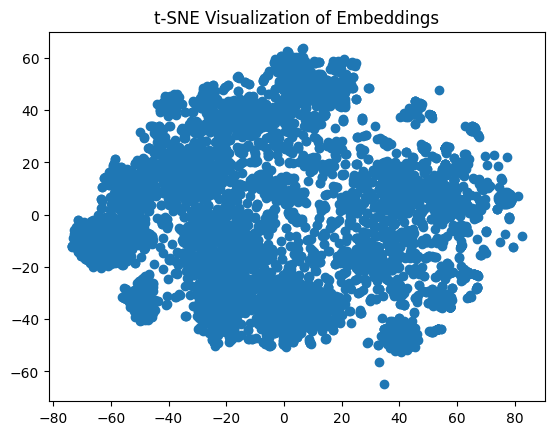

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fetch only embeddings from MongoDB
all_embeddings_cursor = collection.find({}, {"embedding": 1, "_id": 0})
all_embeddings = [doc['embedding'] for doc in all_embeddings_cursor]

# Convert to numpy array
all_embeddings = np.array(all_embeddings)

tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(all_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title("t-SNE Visualization of Embeddings")
plt.show()

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example query embedding
query = "good things user have said"
query_embedding = model.encode([query])

# Retrieve stored embeddings and review texts from MongoDB
cursor = collection.find({}, {'embedding': 1, 'review_text': 1})
data = [(doc['embedding'], doc['review_text']) for doc in cursor]

# Separate embeddings and review texts
all_embeddings, review_texts = zip(*data)

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
query_embedding = np.array(query_embedding)

# Calculate cosine similarities
similarities = cosine_similarity(query_embedding, all_embeddings)

# Get top n similar reviews
top_n = np.argsort(similarities[0])[-5:][::-1]
for idx in top_n:
    print(f"Review: {review_texts[idx]}, Similarity: {similarities[0][idx]}")

Review: love it nothing but good things to say., Similarity: 0.5093828638141946
Review: nothing but great things to say., Similarity: 0.49576644136600295
Review: very user friendly, Similarity: 0.4389460522835522
Review: is good, Similarity: 0.41661980720902314
Review: good stuff, Similarity: 0.41178308316256446
